<a href="https://colab.research.google.com/github/juhhg/RC-Tutorial-2023/blob/main/chapter_5_information_processing_capacity_basic_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter V: Information Processing Capacity


In this chapter, we introduce a measure to evaluate past inputs held in the reservoir called an information processing capacity (IPC).

### Goals in Chapter V
- Understand the IPC
- Understand the relationship among dynamics, rank, and IPC of an echo state network (ESN)
- Learn to measure the IPC of the ESN using a module in our GitHub


### Information Processing Capacity
The state equation is described by
$$
\boldsymbol{x}_{t+1} = \boldsymbol{g}(\boldsymbol{x}_{t},\zeta_{t}).
$$
Let $\zeta_t$ be a random number following the uniform distribution in the range of $[-1,1]$.
The target output is a product of the Legendre polynomials of delayed input
\begin{align}
z_t^{(i)} &= P(\zeta_{t-1},\zeta_{t-2},\ldots) \\
&= \prod_{k} P_{n_k} (\zeta_{t-k}),
\end{align}
where $P_n(\zeta)$ is the $n$th-order Legendre polynomial.
This polynomial is given by the following recurrence equation
$$
(n+1)P_{n+1}(x) = (2n+1)xP_n(x)-nP_{n-1}(x), \tag{1}
$$
where $P_0(x)=1$ and $P_1(x)=x$.
For example, the second and third polynomials are
\begin{align}
P_2(x) = (3x^2-1)/2, \\
P_3(x) = (5x^3-3x)/2,
\end{align}
respectively.

The output is given by
\begin{align}
\hat{z}_t^{(i)} &= \sum_{j=1}^N \hat{w}_j^{(i)} x_{j,t},
\end{align}
where the optimum weights are calculated by the linear regression. Note that, unlike the memory capacity, there is no bias term because the target has time average of $0$ and does not require the bias term to emulate.

The normalized mean square error (NMSE) is
$$
{\rm NMSE} = \frac{\sum_{t=1}^{T} (z_t-\hat{z}_t)^2}{\sum_{t1}^{T} z_t^2}.
$$
Note that the training and evaluation phases are unified in the procedure of calculating IPC.

The IPC is defined by
\begin{align}
C(\boldsymbol{X},\boldsymbol{z}^{(i)}) = 1-{\rm NMSE}_i.
\end{align}
As $0\le{\rm NMSE}\le1$,
$$
0\le C(\boldsymbol{X},\boldsymbol{z}^{(i)})\le1.
$$
Unlike the memory capacity, the IPC strictly takes this range because the training and evaluation phases are not separated.

#### Inner Product
Let the $i$th target polynomial be $z_{i,t}$
The inner product between the target polynomials is defined by
$$
I_{i,j} = \sum_{t=1}^T \frac{z_{i,t}}{\sqrt{\sum_{t=1}^Tz_{i,t}^2}} \frac{z_{j,t}}{\sqrt{\sum_{t=1}^Tz_{j,t}^2}},
$$
where $z_{t}$ is divided by the L2 norm of the time-series $\{z_{1}\cdots z_{T}\}$ to normalize it.
Therefore,
$$
I_{i,j} =
\begin{cases}
1 & (i=j) \\
0 & (i\neq j)
\end{cases}.
$$

#### Practice #1
Let $\zeta_t$ be the uniformly random number in the range of $[-1,1]$.
1. Check the orthonormailty between $z_{1,t}=P_1(\zeta_{t})=\zeta_{t}$ and $z_{2,t}=P_2(\zeta_{t})=(3\zeta_{t}^2-1)/2$ by calculating their inner product.
1. Derive the fourth-order Legendre polynomial $P_4(\zeta)$ using Eq. (1) and check the orthonormailty between $z_{1,t}=P_1(\zeta_{t})=\zeta_{t}$ and $z_{4,t}=P_4(\zeta_{t})$ by calculating their inner product.

Here is an example to calculate the inner product between $z_{1,t}=\zeta_{t-1}$ and $z_{2,t}=\zeta_{t-2}$.

In [ ]:
import numpy as np
Two,T = 10,int(1e6)
np.random.seed(0)
zeta = 2*np.random.rand(Two+T)-1

z1 = zeta[Two-1:Two+T-1]
z2 = zeta[Two-2:Two+T-2]
I11 = z1/np.linalg.norm(z1) @ z1/np.linalg.norm(z1)
I12 = z1/np.linalg.norm(z1) @ z2/np.linalg.norm(z2)
I22 = z2/np.linalg.norm(z2) @ z2/np.linalg.norm(z2)
print('I11',I11,'I12',I12,'I22',I22)

I11 1.0000000000000013 I12 -0.0009640493323256125 I22 0.9999999999999992


### Relationship Between IPC and Rank
A total capacity $C_{\rm tot}$ is descibed by the sum of IPC
$$
C_{\rm tot} = \sum_{i=1}^\infty C(\boldsymbol{X},\boldsymbol{z}^{(i)}).
$$
The total capacity is bounded by the rank $r$, i.e.,
$$
C_{\rm tot} \le r,
$$
where $r$ is the rank of correlation matrix $\boldsymbol{X}^\top\boldsymbol{X}$ and thus $r\le N$.

### Calculate IPCs with Hard-Code (べた書き)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Class of ESN (for a single task)
class ESN():
    def __init__(self,N,rho,sigma,p,pin,rseed=0):
        self.N,self.rho,self.sigma,self.p,self.pin = N,rho,sigma,p,pin
        np.random.seed(rseed)
        W = np.random.uniform(-1,1,(N,N))*(np.random.uniform(0,1,(N,N))<p)
        eigs = np.linalg.eigvals(W)
        self.W = rho*W/np.max(np.abs(eigs))
        np.random.seed(rseed+1)
        self.Win = np.random.uniform(-sigma,sigma,N)*(np.random.uniform(0,1,N)<pin)

    def run(self,u,f=np.tanh,X0=[]):
        if len(X0)==0:
            X0 = np.ones(self.N)
        T = len(u)
        X = np.zeros((T,self.N))
        X[0] = X0
        for t in range(1,T):
            X[t] = f(self.W @ X[t-1] + self.Win*u[t-1])
        return X

    def linear_regression(self,X,z):
        # Calculate wout and output
        wout = np.linalg.pinv(X) @ z
        zhat = X @ wout
        # Normalized mean square error
        nmse = np.mean((zhat - z) ** 2)/np.mean(z**2)
        return nmse


In [ ]:
# Parameters for ESN
Two,T = 1000,int(1e6)
N = 10
rho,sigma = 0.1,0.1
p,pin = 1,1

# Input sequence
np.random.seed(0)
u = np.random.rand(Two+T)
zeta = 2*u-1

# Run ESN
esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u) # Inject asymmetric input
Xwo = X[Two:]

# Debias state matrix after washout
Xwo = Xwo - Xwo.mean(axis=0)

# Rank of state time-series
rank = np.linalg.matrix_rank(Xwo.T@Xwo)
print('Rank',rank)

Rank 10


The target of the first-order capacity is described by
$$
z_t = \zeta_{t-\tau}.
$$

MC (sum of 1st-order capacities) 5.119917134054669


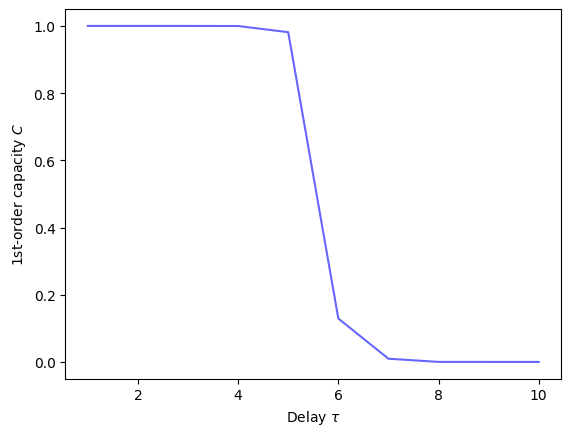

In [ ]:
# First-order capacities
delay1_max = 10
tau1s = np.arange(1,delay1_max+1)
c1 = np.zeros(len(tau1s))
for i,tau in enumerate(tau1s):
    z = zeta[Two-tau:Two+T-tau]
    nmse = esn.linear_regression(Xwo,z)
    c1[i] = 1-nmse

plt.figure()
plt.plot(tau1s,c1,c='blue',alpha=0.6)
plt.xlabel(r'Delay $\tau$')
plt.ylabel(r'1st-order capacity $C$')

print('MC (sum of 1st-order capacities)',np.sum(c1))

The target of second-order capacity has two delays $\tau_1,\tau_2~(\tau_1\le\tau_2)$ and thus is described by
$$
z_t = P(\zeta_{t-\tau_1},\zeta_{t-\tau_2}).
$$
The targets of second-order capacities are classified based on the delays $\tau_1,\tau_2$
$$
z_t = \begin{cases}
P_2(\zeta_{t-\tau_1})=(3\zeta_{t-\tau_1}^2-1)/2 & (\tau_1=\tau_2) \\
P_1(\zeta_{t-\tau_1})P_1(\zeta_{t-\tau_2})=\zeta_{t-\tau_1}\zeta_{t-\tau_2} & (\tau_1<\tau_2)
\end{cases}.
$$


Sum of 2nd-order capacities 4.601164551995499


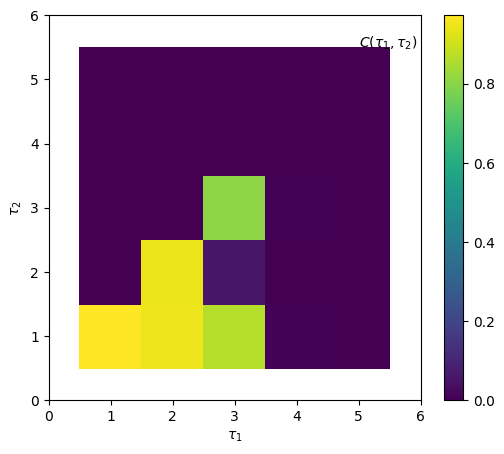

In [ ]:
# Second-order capacites
delay2_max = 5
tau2s = np.arange(1,delay2_max+1)
c2 = np.zeros((len(tau2s),len(tau2s)))
for i,tau1 in enumerate(tau2s):
    for j,tau2 in enumerate(tau2s):
        if i<=j:
            if i==j:
                z = (3*np.power(zeta[Two-tau1:Two+T-tau1],2)-1)/2
            else:
                z = zeta[Two-tau1:Two+T-tau1] * zeta[Two-tau2:Two+T-tau2]
            nmse = esn.linear_regression(Xwo,z)
            c2[i,j] = 1-nmse

fig,ax = plt.subplots(figsize=(6,5))
c = ax.pcolor(tau2s,tau2s,c2)
fig.colorbar(c, ax=ax)
ax.set_xlim(0,delay2_max+1)
ax.set_ylim(0,delay2_max+1)
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$\tau_2$')
ax.text(5,5.5,r'$C(\tau_1,\tau_2)$')

print('Sum of 2nd-order capacities',np.sum(c2))

Based on the delays $\tau_1,\tau_2,\tau_3~(\tau_1\le\tau_2\le\tau_3)$, the targets of third-order capacities are classified as
$$
z_t = \begin{cases}
P_3(\zeta_{t-\tau_1}) = (5\zeta_{t-\tau_1}^3-3\zeta_{t-\tau_1})/2 & (\tau_1=\tau_2=\tau_3) \\
P_2(\zeta_{t-\tau_1})P_1(\zeta_{t-\tau_3}) = (3\zeta_{t-\tau_1}^2-1)/2\cdot \zeta_{t-\tau_3} & (\tau_1=\tau_2<\tau_3) \\
P_1(\zeta_{t-\tau_1})P_2(\zeta_{t-\tau_2}) = \zeta_{t-\tau_1}\cdot (3\zeta_{t-\tau_2}^2-1)/2 & (\tau_1<\tau_2=\tau_3) \\
P_1(\zeta_{t-\tau_1})P_1(\zeta_{t-\tau_2})P_1(\zeta_{t-\tau_3}) = \zeta_{t-\tau_1}\cdot\zeta_{t-\tau_2}\cdot\zeta_{t-\tau_3} & (\tau_1<\tau_2<\tau_3)
\end{cases}
$$

Sum of 3rd-order capacities 0.27780758011928475


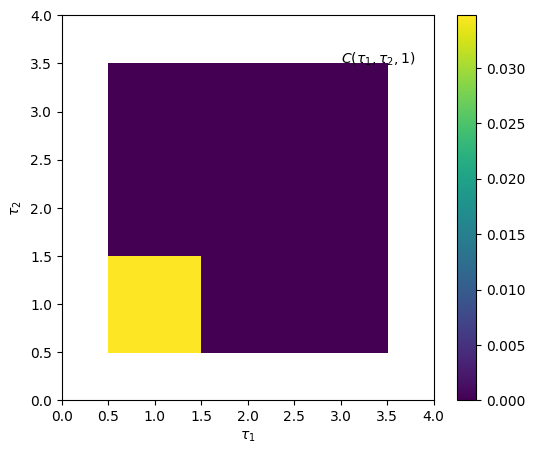

In [ ]:
# Third-order capacites
delay3_max = 3
tau3s = np.arange(1,delay3_max+1)
c3 = np.zeros((len(tau3s),len(tau3s),len(tau3s)))
for i,tau1 in enumerate(tau3s):
    for j,tau2 in enumerate(tau3s):
        for k,tau3 in enumerate(tau3s):
            if (i<=j) and (j<=k):
                if i==j:
                    if j==k: # tau1=tau2=tau3
                        z = (5*np.power(zeta[Two-tau1:Two+T-tau1],3)-3*zeta[Two-tau1:Two+T-tau1])/2
                    else: # tau1=tau2<tau3
                        z = (3*np.power(zeta[Two-tau1:Two+T-tau1],2)-1)/2 * zeta[Two-tau3:Two+T-tau3]
                else:
                    if j==k: # tau1<tau2=tau3
                        z = zeta[Two-tau1:Two+T-tau1] * (3*np.power(zeta[Two-tau2:Two+T-tau2],2)-1)/2
                    else: # tau1<tau2<tau3
                        z = zeta[Two-tau1:Two+T-tau1] * zeta[Two-tau2:Two+T-tau2] * zeta[Two-tau3:Two+T-tau3]
                nmse = esn.linear_regression(Xwo,z)
                c3[i,j,k] = 1-nmse

fig,ax = plt.subplots(figsize=(6,5))
c = ax.pcolor(tau3s,tau3s,c3[:,:,0])
fig.colorbar(c, ax=ax)
ax.set_xlim(0,delay3_max+1)
ax.set_ylim(0,delay3_max+1)
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$\tau_2$')
ax.text(3,3.5,r'$C(\tau_1,\tau_2,1)$')

print('Sum of 3rd-order capacities',np.sum(c3))

In [ ]:
Ctot = np.sum(c1) + np.sum(c2) + np.sum(c3)
print('Total capacity',Ctot,'rank',rank)


Total capacity 9.998889266169453 rank 10


### Method to Calculate IPCs Easier and Faster
Two problems
- Too many polynomials
- Takes long time to compute them

We published a code to compute IPC easier and faster on the GitHub (https://github.com/kubota0130/ipc).

#### Prepare GPU environment
1. Enabling GPU

 In a default settings, your GPU is not available. To enable the GPU in your notebook, please select the following option

 (English)  [Edit] > [Notebook settings] > [Hardware Accrelerator] > [GPU]

 (日本語) [編集] > [ノートブックの設定] > [ハードウェア アクセラレータ] > [GPU]


2. Check CUDA version

In [ ]:
# Use UTF-8 encoding (the above Japanese sentence may change the encoding)
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!/usr/local/cuda/bin/nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


3. Install CuPy

In [ ]:
# Installation for CUDA v11.2 (see https://docs.cupy.dev/en/stable/install.html)
!pip install cupy-cuda11x


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


3. Check available GPUs

In [ ]:
!nvidia-smi

total 131380
-rwxr-xr-x 1 root root    88848 Sep 21  2022 bin2c
-rwxr-xr-x 1 root root      115 Aug 26  2022 compute-sanitizer
drwxr-xr-x 2 root root     4096 Feb  2 05:34 crt
-rwxr-xr-x 1 root root  6693560 Sep 21  2022 cudafe++
-rwxr-xr-x 1 root root 13686120 Aug 26  2022 cuda-gdb
-rwxr-xr-x 1 root root   778624 Aug 26  2022 cuda-gdbserver
-rwxr-xr-x 1 root root   356336 Aug 25  2022 cuda-memcheck
-rwxr-xr-x 1 root root    75928 Aug 26  2022 cu++filt
-rwxr-xr-x 1 root root   503200 Aug 25  2022 cuobjdump
-rwxr-xr-x 1 root root   281744 Sep 21  2022 fatbinary
-rwxr-xr-x 1 root root 15006120 Sep 21  2022 nvcc
-rwxr-xr-x 1 root root   667216 Sep 21  2022 __nvcc_device_query
-rw-r--r-- 1 root root      417 Sep 21  2022 nvcc.profile
-rwxr-xr-x 1 root root 51518152 Aug 26  2022 nvdisasm
-rwxr-xr-x 1 root root 19628856 Sep 21  2022 nvlink
-rwxr-xr-x 1 root root  5730336 Aug 27  2022 nvprof
-rwxr-xr-x 1 root root   109552 Aug 26  2022 nvprune
-rwxr-xr-x 1 root root 19369040 Sep 21  2022 ptxa

#### Put `utils` module in the current directory
1. Clone `ipc` module from github
2. Move `utils` module to current directory
3. Remove non-necessary files

In [ ]:
!git clone https://github.com/kubota0130/ipc.git #1
!mv ipc/utils . #2
!rm -r ipc #3
!ls -l

Cloning into 'ipc'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 78 (delta 38), reused 49 (delta 18), pack-reused 0
Unpacking objects: 100% (78/78), 431.45 KiB | 626.00 KiB/s, done.
total 8
drwxr-xr-x 1 root root 4096 May 30 13:34 sample_data
drwxr-xr-x 2 root root 4096 Jun  1 06:40 utils


#### Compute IPCs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cupy as cp
from utils.information_processing_capacity import single_input_ipc

# Class of ESN (for a single task)
class ESN():
    def __init__(self,N,rho,sigma,p,pin,rseed=0):
        self.N,self.rho,self.sigma,self.p,self.pin = N,rho,sigma,p,pin
        np.random.seed(rseed)
        W = np.random.uniform(-1,1,(N,N))*(np.random.uniform(0,1,(N,N))<p)
        eigs = np.linalg.eigvals(W)
        self.W = rho*W/np.max(np.abs(eigs))
        np.random.seed(rseed+1)
        self.Win = np.random.uniform(-sigma,sigma,N)*(np.random.uniform(0,1,N)<pin)

    def run(self,u,f=np.tanh,X0=[]):
        if len(X0)==0:
            X0 = np.ones(self.N)
        T = len(u)
        X = np.zeros((T,self.N))
        X[0] = X0
        for t in range(1,T):
            X[t] = f(self.W @ X[t-1] + self.Win*u[t-1])
        return X

First, we demonstrate how to compute IPCs using an ESN.
The ESN has 50 nodes and receives a uniform random input.

In [ ]:
##### Parameters for esn #####
N = 100      # Number of nodes
Two = 10000 # Washout time
T = int(1e6)# Time length except washout
p = 1     # Sparsity for internal weight
pin = 1   # Sparsity for input weight
sigma = 0.1  # Input intensity
rhos = np.arange(0.1,1.7,0.1)  # Spectral radius
# rhos = np.arange(1.3,1.9,0.1)  # Spectral radius

##### Input #####
np.random.seed(0)
u = np.random.rand(Two+T)
zeta = 2*u-1
print('zeta',zeta,zeta.shape)

zeta [ 0.09762701  0.43037873  0.20552675 ...  0.61867435 -0.30313547
 -0.51697079] (1010000,)


Here we use the Legendre polynomial with uniform random input.
To compute IPCs, we need to set `degdelays`, which is sets of degree and maximum delay and determine the search range of polynomials.
For example, `[1,2000]` means that the maximum delay is 2000 for first-order terms (i.e., $\{\zeta_{t},\zeta_{t-1},\ldots,\zeta_{t-2000}\}$).

In [ ]:
# Parameters for IPC
poly = 'legendre'
distr = 'uniform'
degdelays = [[1,2000],[2,300],[3,50],[4,30],[5,15]]
# Class for IPC
ipc = single_input_ipc(zeta,Two,degdelays,poly=poly,distr=distr,zerobased=True)

Here we set the gpu id to `0`.

In [ ]:
gpu_id = 0
cp.cuda.Device(gpu_id).use()

<CUDA Device 0>

Basically, we can compute IPCs through the following procedure:
1. Compute state time series
  To compute IPCs, we need input sequence `zeta` and state time seies `x`.
  In the following code, we obtained state time series of the ESN.

2. Perform singular value decomposition (SVD)
  `ipc.svd(x)` performs the SVD.
  Let `N`, `Two`, and `T` be the number of nodes, washout time, and time length except washout, respectively, and `x.shape` must be `(N,Two+T)`.
  The SVD reduces the dimension of state $N$ to the rank $r$ ($x_t\in\mathbb{R}^{N}$ to $\hat{x}_t\in\mathbb{R}^r$).
  We can check the rank by `ipc.rank` and the reduced state by `ipc.P`.
    
3. Compute IPCs
  From `ipc.compute(deg,delay)`, we get IPCs `ipcs` and shuffle surrogate data `surs`.
  However, the IPCs include numerical errors and the sum of them has a large error.
  Therefore, using `surs` and thresholds (see Appendix B in [2]), we get truncated IPCs `truncated`.

Also, we need to determine filenames.
We get IPCs in pickle files (`.pkl`) and variables for IPCs in a JSON file (`.json`).
`ipc.save_config(path)` saves the config file using the argument of `path`.
For example, if `path = 'ipc/pkl/test'`, the config file will be saved as `ipc/pkl/test.json`
and the pickle files will be `ipc/pkl/test_ipc_X_Y.pkl`, where `X` and `Y` are degree and maximum delay, respectively.
Please specify `pkldir` and `path`.

In [ ]:
# Directory
pkldir = 'ipc/pkl'
for rho in rhos:

    print('Spectral radius',rho)

    esn = ESN(N,rho,sigma,p,pin)
    X = esn.run(zeta)

    ##### Compute IPC of ESN state #####
    ipc.svd(X.T)
    path = '%s/state_%d_%5.3f_%5.3f_%5.3f_%5.3f'%(pkldir,N,p,pin,rho,sigma)
    ipc.save_config(path)
    Ctot = 0
    for deg,delay in degdelays:
      ipcs,surs = ipc.compute(deg,delay)
      truncated = ipc.threshold(ipcs,surs,deg,delay,th_scale=1.2)
      Ctot_deg = np.sum(truncated['ipcs'].values)
      print('deg',deg,'delay',delay,'Ctot(d)',Ctot_deg)
      Ctot += Ctot_deg
    print('degs',ipc.degs,'Ctot',Ctot,'rank',ipc.rank)
    print('--------------------------------------------------------------------------------\n\n\n')


Spectral radius 0.1
{'N': 100, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 2000], [2, 300], [3, 50], [4, 30], [5, 15]], 'zerobased': True, 'poly': 'legendre', 'distr': 'uniform', 'thresh': 'N', 'finfo': 2.220446049250313e-16, 'rank': 19}
Making degdelaysets of 1-order 2000-delay
  degdelaysets      ipcs
1     [[1, 1]]  0.999998
2     [[1, 2]]  0.999998
3     [[1, 3]]  0.999998
4     [[1, 4]]  0.999998
5     [[1, 5]]  0.999993
6     [[1, 6]]  0.999878
7     [[1, 7]]  0.996515
8     [[1, 8]]  0.000360
deg 1 delay 2000 Ctot(d) 6.996736318407071
Making degdelaysets of 2-order 300-delay


/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


               degdelaysets      ipcs
410       [[1, 3], [1, 28]]  0.000051
1084      [[1, 2], [1, 46]]  0.000049
2420      [[1, 4], [1, 69]]  0.000047
2929      [[1, 2], [1, 76]]  0.000056
4468      [[1, 2], [1, 94]]  0.000048
4540     [[1, 74], [1, 94]]  0.000053
4636     [[1, 75], [1, 95]]  0.000054
6906     [[1, 2], [1, 117]]  0.000052
8684    [[1, 37], [1, 131]]  0.000048
9173   [[1, 127], [1, 134]]  0.000050
11150  [[1, 123], [1, 148]]  0.000051
18036   [[1, 80], [1, 189]]  0.000047
18686  [[1, 157], [1, 192]]  0.000048
18880  [[1, 158], [1, 193]]  0.000050
21531    [[1, 2], [1, 207]]  0.000052
29119  [[1, 198], [1, 240]]  0.000048
31754  [[1, 127], [1, 251]]  0.000048
33819  [[1, 148], [1, 259]]  0.000050
35237  [[1, 256], [1, 264]]  0.000048
44466  [[1, 212], [1, 297]]  0.000050
deg 2 delay 300 Ctot(d) 0.0009996278372978193
Making degdelaysets of 3-order 50-delay


/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


                     degdelaysets      ipcs
51                       [[3, 1]]  0.999999
53               [[1, 2], [2, 1]]  0.999998
54               [[1, 3], [2, 1]]  0.999970
55               [[1, 4], [2, 1]]  0.998096
56               [[1, 5], [2, 1]]  0.000786
...                           ...       ...
22783  [[1, 1], [1, 35], [1, 50]]  0.000046
22784  [[1, 2], [1, 35], [1, 50]]  0.000047
22785  [[1, 3], [1, 35], [1, 50]]  0.000053
22934  [[1, 2], [1, 39], [1, 50]]  0.000048
23330  [[1, 2], [1, 48], [1, 50]]  0.000051

[149 rows x 2 columns]
deg 3 delay 50 Ctot(d) 12.009173003880194
Making degdelaysets of 4-order 30-delay


/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


                              degdelaysets      ipcs
6                 [[1, 2], [1, 3], [2, 0]]  0.000052
81               [[1, 2], [1, 13], [2, 0]]  0.000050
494               [[1, 5], [1, 7], [2, 1]]  0.000051
521              [[1, 8], [1, 10], [2, 1]]  0.000060
536              [[1, 2], [1, 12], [2, 1]]  0.000053
...                                    ...       ...
45624  [[1, 1], [1, 13], [1, 28], [1, 30]]  0.000046
45786  [[1, 3], [1, 22], [1, 28], [1, 30]]  0.000055
45837  [[1, 5], [1, 24], [1, 28], [1, 30]]  0.000053
45838  [[1, 3], [1, 24], [1, 28], [1, 30]]  0.000052
45840  [[1, 2], [1, 24], [1, 28], [1, 30]]  0.000046

[533 rows x 2 columns]
deg 4 delay 30 Ctot(d) 0.027796399989490933
Making degdelaysets of 5-order 15-delay


/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


                                       degdelaysets      ipcs
23                 [[1, 1], [1, 2], [1, 5], [2, 0]]  0.000066
25                 [[1, 1], [1, 3], [1, 5], [2, 0]]  0.000066
26                 [[1, 2], [1, 3], [1, 5], [2, 0]]  0.000061
217               [[1, 1], [1, 8], [1, 11], [2, 0]]  0.000058
592                                        [[5, 1]]  0.000506
...                                             ...       ...
15153    [[1, 2], [1, 6], [1, 8], [1, 14], [1, 15]]  0.000061
15162    [[1, 0], [1, 1], [1, 9], [1, 14], [1, 15]]  0.000049
15266   [[1, 1], [1, 2], [1, 11], [1, 14], [1, 15]]  0.000049
15298   [[1, 2], [1, 6], [1, 11], [1, 14], [1, 15]]  0.000064
15483  [[1, 3], [1, 12], [1, 13], [1, 14], [1, 15]]  0.000048

[317 rows x 2 columns]
deg 5 delay 15 Ctot(d) 0.020179062828312583
degs [1 2 3 4 5] Ctot 19.054884412942364 rank 19
--------------------------------------------------------------------------------



Spectral radius 0.2
{'N': 100, 'T': 1000000, 'Two': 100

As a result, we get IPCs `ipcs` and can check them by `ipcs`.
For example, the first-order one is
```
     degdelaysets      ipcs
1        [[1, 1]]  0.999998
2        [[1, 2]]  0.999998
3        [[1, 3]]  0.999998
4        [[1, 4]]  0.999998
5        [[1, 5]]  0.999997
6        [[1, 6]]  0.999959
7        [[1, 7]]  0.998000
8        [[1, 8]]  0.031181
9        [[1, 9]]  0.000074
```
and the third-order one is
```
                    degdelaysets      ipcs
51                       [[3, 1]]  0.999999
53               [[1, 2], [2, 1]]  0.999824
54               [[1, 3], [2, 1]]  0.999129

```
where `degdelaysets` means a family of sets of degrees and delays for a polynomial.
Two numbers in an inner square bracket are degree and delay (i.e., [[degree#1,delay#1],[degree#2,delay#2],...]).
For example, in a case of `[[1,3],[2,1]]`, the target is orthogonalized polynomial of $\zeta_{t-3} \zeta_{t-1}^2$.

We can also see the truncated IPCs by `truncated`.
`Ctot_deg` [or `Ctot(d)`] denotes the dth-order IPC decomposition, which is the sum of dth-order truncated IPCs.


To easily plot IPC decomposition, we prepare a method `ipc.get_indicators(npzname,paths)`.  
After specifying a `.npz` file name, we can get some indicators from the method.
In a case of plotting IPC decomposition, we can use `ipc.ipcs_degree`, which is the dth-order IPC decomposition as a function of `rhos`.

#### Plot IPC Decomposition

{'ipcs_degree': array([[6.99673632e+00, 0.00000000e+00, 1.20040799e+01, 5.82011614e-03,
        7.49274032e-03],
       [9.38714011e+00, 0.00000000e+00, 2.85519716e+01, 1.00284880e-02,
        8.85942596e-02],
       [1.17941311e+01, 0.00000000e+00, 4.61199310e+01, 1.57942772e-02,
        1.26341239e-01],
       [1.40854135e+01, 0.00000000e+00, 6.94694394e+01, 5.09475896e-02,
        5.42311925e-01],
       [1.60779719e+01, 0.00000000e+00, 8.35484716e+01, 2.44907148e-02,
        5.37876840e-01],
       [1.80728867e+01, 0.00000000e+00, 8.19011835e+01, 3.06997076e-02,
        1.72641317e-01],
       [2.05709079e+01, 0.00000000e+00, 7.94565596e+01, 2.93267709e-02,
        8.67134146e-02],
       [2.39595789e+01, 0.00000000e+00, 7.60949109e+01, 8.54164021e-03,
        5.55915990e-02],
       [2.87844160e+01, 0.00000000e+00, 7.12973305e+01, 1.40303094e-03,
        4.56987305e-02],
       [3.23643553e+01, 0.00000000e+00, 4.50073399e+01, 4.42381493e-04,
        5.29174038e-03],
       [2.3531

Text(0, 0.5, '$C_{\\rm tot}$')

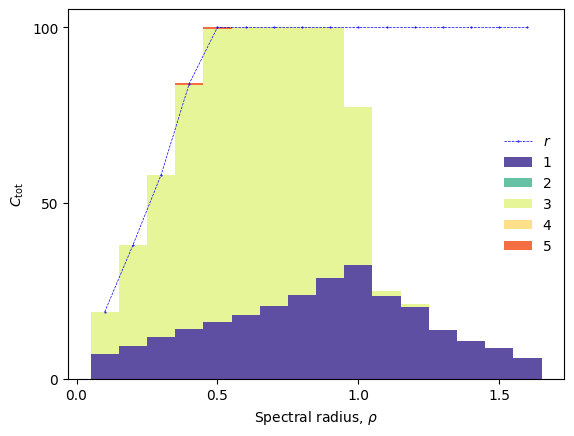

In [ ]:
# Paths for loading data
paths = []
for rho in rhos:
	path = '%s/state_%d_%5.3f_%5.3f_%5.3f_%5.3f'%(pkldir,N,p,pin,rho,sigma)
	paths.append(path)

# Compute various indicators from IPCs
npzname = 'ipc/npz/state_indicators_%d_%5.3f_%5.3f_%5.3f'%(N,p,pin,sigma)
ipc.get_indicators(npzname,paths,th_scale=1.5)

# Plot ipc decomposition
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(rhos,ipc.ranks,c='b',ls='--',marker='.',ms=1,lw=0.5,label=r'$r$')
bottom = np.zeros(rhos.shape)
for i,deg in enumerate(ipc.degs):
	ax.bar(rhos,ipc.ipcs_degree[:,i],width=0.1,bottom=bottom,label=deg,color=cm.Spectral_r((deg-1)/ipc.degmax),ec=None)
	bottom += ipc.ipcs_degree[:,i]
ax.legend(loc='right',frameon=False,ncol=1)
ax.set_xticks([0,0.5,1,1.5])
ax.set_xlabel(r'Spectral radius, $\rho$')
ax.set_yticks([0,50,100])
ax.set_ylabel(r'$C_{\rm tot}$')

<ipython-input-17-8d6e10c3cac1>:42: RuntimeWarning: divide by zero encountered in log
  l = np.log(np.abs(np.linalg.eigvals(M)))/T
<ipython-input-17-8d6e10c3cac1>:73: RuntimeWarning: divide by zero encountered in log
  l = np.log(np.abs(np.linalg.eigvals(M)))/T


Text(0, 0.5, '$C_{\\rm tot}$')

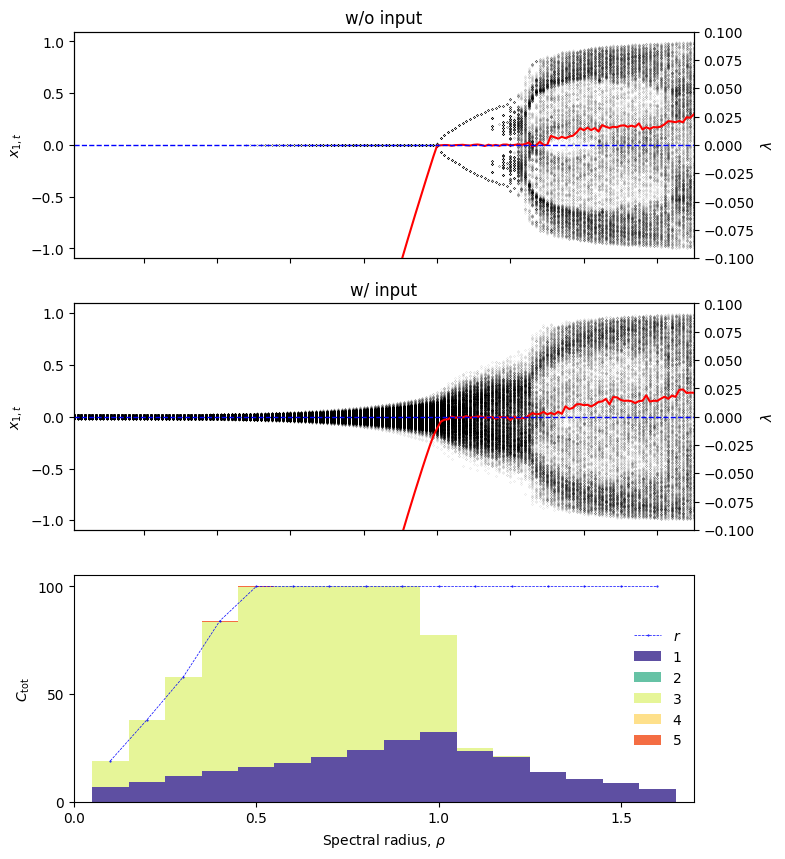

In [ ]:
import scipy as sp

# Parameters
Two,Ttrain,Teval = 1000,1000,1000
T = Ttrain + Teval

N = 100
rhos_bif = np.arange(0.01,1.71,0.01)
# rhos_bif = np.arange(0.1,2.01,0.1)
sigma = 0.1
# p,pin = 0.5,0.1
p,pin = 1,1

# Input
np.random.seed(0)
u = np.random.rand(Two+T)
zeta = 2*u - 1

# Parameters for MC
taus = np.arange(1,80) #delay

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(311)

mcs,ls = [],[]
for rho in rhos_bif:
    esn = ESN(N,rho,sigma,p,pin)
    X = esn.run(0*zeta,f=np.tanh)
    Xwo = np.hstack([X[Two:],np.ones((T,1))])
    X0 = X[Two:,0]
    index_positive = sp.signal.find_peaks( X0)[0]
    index_negative = sp.signal.find_peaks(-X0)[0]
    index = np.concatenate([index_positive,index_negative])
    X0 = X0[index]
    ax.plot(rho*np.ones(len(X0)),X0,c='k',marker='.',ms=0.1,ls='')

    M = np.eye(N)
    for t in range(Two,Two+T):
        J = np.diag( 1-X[t]**2 ) @ esn.W
        M = J @ M

    l = np.log(np.abs(np.linalg.eigvals(M)))/T
    ls.append(l.max())

ax.set_xlim(rhos_bif.min(),rhos_bif.max())
ax.set_xticklabels([])
ax.set_ylabel(r'$x_{1,t}$')
ax.set_title('w/o input')
ax2 = ax.twinx()
ax2.plot(rhos_bif,ls,c='r',ls='-')
ax2.plot([rhos_bif.min(),rhos_bif.max()],[0,0],c='b',ls='--',lw=1)
ax2.set_ylim(-0.1,0.1)
ax2.set_ylabel(r'$\lambda$')

ax = fig.add_subplot(312)
ls = []
for rho in rhos_bif:
    esn = ESN(N,rho,sigma,p,pin)
    X = esn.run(zeta,f=np.tanh)
    Xwo = np.hstack([X[Two:],np.ones((T,1))])
    X0 = X[Two:,0]
    index_positive = sp.signal.find_peaks( X0)[0]
    index_negative = sp.signal.find_peaks(-X0)[0]
    index = np.concatenate([index_positive,index_negative])
    X0 = X0[index]
    ax.plot(rho*np.ones(len(X0)),X0,c='k',marker='.',ms=0.1,ls='')

    M = np.eye(N)
    for t in range(Two,Two+T):
        J = np.diag( 1-X[t]**2 ) @ esn.W
        M = J @ M

    l = np.log(np.abs(np.linalg.eigvals(M)))/T
    ls.append(l.max())

ax.set_xlim(rhos_bif.min(),rhos_bif.max())
ax.set_xticklabels([])
ax.set_ylabel(r'$x_{1,t}$')
ax.set_title('w/ input')
ax2 = ax.twinx()
ax2.plot(rhos_bif,ls,c='r',ls='-')
ax2.plot([rhos_bif.min(),rhos_bif.max()],[0,0],c='b',ls='--',lw=1)
ax2.set_ylim(-0.1,0.1)
ax2.set_ylabel(r'$\lambda$')

ax = fig.add_subplot(313)
ax.plot(rhos,ipc.ranks,c='b',ls='--',marker='.',ms=1,lw=0.5,label=r'$r$')
bottom = np.zeros(rhos.shape)
for i,deg in enumerate(ipc.degs):
	ax.bar(rhos,ipc.ipcs_degree[:,i],width=0.1,bottom=bottom,label=deg,color=cm.Spectral_r((deg-1)/ipc.degmax),ec=None)
	bottom += ipc.ipcs_degree[:,i]
ax.legend(loc='right',frameon=False,ncol=1)
ax.set_xlim(rhos_bif.min(),rhos_bif.max())
ax.set_xticks([0,0.5,1,1.5])
ax.set_xlabel(r'Spectral radius, $\rho$')
ax.set_yticks([0,50,100])
ax.set_ylabel(r'$C_{\rm tot}$')



#### Practice #2
1. Illustrate the bifurcation diagram, the maximum Lyapunov exponent, and the IPC decomposition using the 50-node ESN.



#### Plot Memory Functions

The above scripts illustrate the total capacities of ESN, but it does not show its dependency on delays. Here we explain first- and second-order memory functions using an ESN.

To depict both the first- and second-order memory functions, we employed an asymmetric input $u_t\in[0,1]$, which is injected to the ESN, because the ESN with a symmetric input holds only odd-order capacities.
Note that a symmetric input $\zeta_t=2u_t-1\in[-1,1]$ is used for IPC calculation.

In [ ]:
# Parameters for ESN
Two,T = 10000,int(1e6)
N = 50
rho,sigma = 0.9,0.1
p,pin = 1,1

# Input sequence
np.random.seed(0)
u = np.random.rand(Two+T)
print('Asymmetric input',u,u.shape)
zeta = 2*u-1
print('Symmetric input',zeta,zeta.shape)

# Parameters for IPC
poly = 'legendre'
distr = 'uniform'
degdelays = [[1,100],[2,30]]
# Class for IPC
ipc = single_input_ipc(zeta,Two,degdelays,poly=poly,distr=distr,zerobased=True)

gpu_id = 0
cp.cuda.Device(gpu_id).use()

# Directory
pkldir = 'ipc/pkl'
path = '%s/asym_%d_%5.3f_%5.3f_%5.3f_%5.3f'%(pkldir,N,p,pin,rho,sigma)

Asymmetric input [0.5488135  0.71518937 0.60276338 ... 0.80933717 0.34843226 0.24151461] (1010000,)
Symmetric input [ 0.09762701  0.43037873  0.20552675 ...  0.61867435 -0.30313547
 -0.51697079] (1010000,)


In [ ]:
# ESN
esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u)

##### Compute IPC of ESN state #####
ipc.svd(X.T)
ipc.save_config(path)
Ctot = 0
for deg,delay in degdelays:
    ipcs,surs = ipc.compute(deg,delay)
    truncated = ipc.threshold(ipcs,surs,deg,delay,th_scale=1.2)
    Ctot_deg = np.sum(truncated['ipcs'].values)
    print('deg',deg,'delay',delay,'Ctot(d)',Ctot_deg)
    Ctot += Ctot_deg
print('degs',ipc.degs,'Ctot',Ctot,'rank',ipc.rank)
print('--------------------------------------------------------------------------------\n\n\n')

{'N': 50, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 100], [2, 30]], 'zerobased': True, 'poly': 'legendre', 'distr': 'uniform', 'thresh': 'N', 'finfo': 2.220446049250313e-16, 'rank': 50}
Making degdelaysets of 1-order 100-delay
   degdelaysets      ipcs
1      [[1, 1]]  0.999998
2      [[1, 2]]  0.999997
3      [[1, 3]]  0.999995
4      [[1, 4]]  0.999993
5      [[1, 5]]  0.999987
6      [[1, 6]]  0.999974
7      [[1, 7]]  0.999956
8      [[1, 8]]  0.999926
9      [[1, 9]]  0.999811
10    [[1, 10]]  0.999624
11    [[1, 11]]  0.998965
12    [[1, 12]]  0.998094
13    [[1, 13]]  0.995814
14    [[1, 14]]  0.991924
15    [[1, 15]]  0.987332
16    [[1, 16]]  0.976721
17    [[1, 17]]  0.958736
18    [[1, 18]]  0.937486
19    [[1, 19]]  0.895590
20    [[1, 20]]  0.850949
21    [[1, 21]]  0.792749
22    [[1, 22]]  0.658873
23    [[1, 23]]  0.441338
24    [[1, 24]]  0.327922
25    [[1, 25]]  0.244889
26    [[1, 26]]  0.192929
27    [[1, 27]]  0.175188
28    [[1, 28]]  0.094530
2

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


          degdelaysets      ipcs
2             [[2, 1]]  0.672245
4             [[2, 2]]  0.736444
5     [[1, 1], [1, 2]]  0.898256
7             [[2, 3]]  0.660902
8     [[1, 1], [1, 3]]  0.875086
..                 ...       ...
411  [[1, 4], [1, 28]]  0.000112
437  [[1, 1], [1, 29]]  0.000115
438  [[1, 2], [1, 29]]  0.000126
439  [[1, 3], [1, 29]]  0.000104
468  [[1, 2], [1, 30]]  0.000099

[278 rows x 2 columns]
deg 2 delay 30 Ctot(d) 18.59156836882703
degs [1 2] Ctot 41.35699855351628 rank 50
--------------------------------------------------------------------------------





1. First-order memory function

The first-order memory function $C(\tau)$ describes an input delayed by $\tau$ held in a reservoir and is equivalent to the first-order IPC of $\zeta_{t-\tau}$.
The method `single_input_ipc.mf1d()` returns the first-order memory function `mf1d` $\{C(\tau)\}$ with its corresponding delays `delays` $\{\tau\}$.
Note that, when `zerobased`==True (False), the range of `delays` is from $0$ ($1$) to the maximum delay $\tau_{\rm max}$ in `degdelays` = [[1,$\tau_{\rm max}$]] .

In [ ]:
th_scale = 1.2
delays,mf1d = ipc.mf1d(path,th_scale=th_scale)
print('delay',delays)
print('1st-order capacties',mf1d)

delay [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
1st-order capacties [0, 0.99999753957599, 0.9999969251175921, 0.9999953371768509, 0.9999930899311091, 0.9999868194018281, 0.9999737803103275, 0.9999563765812052, 0.9999255207648984, 0.9998114726063277, 0.9996237795356501, 0.9989653211945015, 0.9980941091393986, 0.9958135930886811, 0.9919235027612145, 0.9873320965360454, 0.9767208916502341, 0.958735920644042, 0.9374858781686926, 0.8955902042046656, 0.850949458745004, 0.7927491571033212, 0.6588729508435902, 0.4413381168795957, 0.3279224918943783, 0.24488878984765816, 0.19292933570135778, 0.17518769228333003, 0.09452992517309401,

The capacities are selected by the shuffle surrogate method.
In this method, we prepare $N_{\rm sur}(=200)$ target time-series shuffled in the time direction with different random seeds and calculate surrogates $C_{{\rm sur},i}~(i=1,\ldots,N_{\rm sur})$, which are capacities calculated with the $N_{\rm sur}$ shuffled targets.
If an original capacity $C(\tau)$ is statistically significant, $C(\tau)$ does not fall within the surrogate distribution.
We set a threshold to $C_{\rm th}=scale\times\max_i(C_{{\rm sur},i})$ and select $C(\tau)$ greater than $C_{\rm th}$.
Note that $C(\tau)~(\tau=0,1,\ldots)$ share the threshold $C_{\rm th}$ because we assume that the input sequence is stationary and thus statistical properties of shuffled delayed input series $\{\zeta_{t-\tau}\}$ (e.g., mean and variance) are independent of $\tau$.

Threshold 0.00011779770007560103


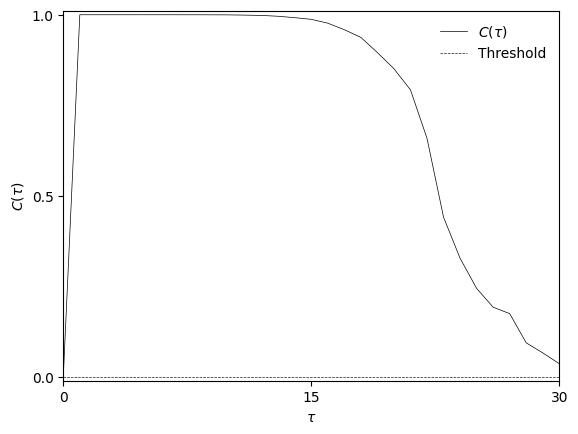

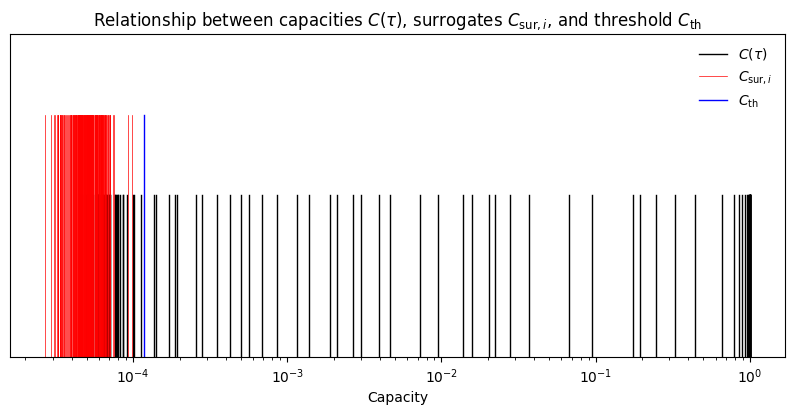

In [ ]:
# If you would like to get the surrogates and threshold, 'return_original' should be set to True.
th_scale = 1.2
delays,mf1d,ipcs,surs = ipc.mf1d(path,th_scale=th_scale,return_original=True)
ipcs = ipcs['ipcs'].values
surs = surs.values[0]
thr = th_scale*surs.max()
print('Threshold',thr)

plt.figure()
plt.plot(delays,mf1d,'k-',lw=0.5,label=r'$C(\tau)$')
plt.plot([delays.min(),delays.max()],[thr,thr],'b--',lw=0.5,label='Threshold')
plt.xlim(0,25)
plt.xlabel(r'$\tau$')
plt.xticks([0,15,30])
plt.ylim(-0.01,1.01)
plt.ylabel(r'$C(\tau)$')
plt.yticks([0,0.5,1])
plt.legend(loc='upper right',frameon=False)
plt.savefig('sample2_1d_memory_function.png',dpi=300,facecolor="w",edgecolor="w")

plt.figure(figsize=[10,4.2])
# Capacities
plt.plot(ipcs[0]*np.ones(2),[0,1],'k-',lw=1,label=r'$C(\tau)$')
[ plt.plot(c*np.ones(2),[0,1],'k-',lw=1) for c in ipcs[1:]]
# Surrogates
plt.plot(surs[0]*np.ones(2),[0,1.5],'r-',lw=0.5,label=r'$C_{{\rm sur},i}$')
[ plt.plot(c*np.ones(2),[0,1.5],'r-',lw=0.5) for c in surs[1:]]
# Threshold
plt.plot(thr*np.ones(2),[0,1.5],'b-',lw=1,label=r'$C_{\rm th}$')
plt.xlabel('Capacity')
plt.xscale('log')
plt.ylim(0,2)
plt.yticks([])
plt.legend(loc='upper right',frameon=False)
plt.title(r'Relationship between capacities $C(\tau)$, surrogates $C_{{\rm sur},i}$, and threshold $C_{\rm th}$')
plt.savefig('sample2_1d_surrogate.png',dpi=300,facecolor="w",edgecolor="w")


2. Second-order memory function

The second-order memory function $C(\tau_1,\tau_2)$ represents the second-order IPC of $\zeta_{t-\tau_1}\zeta_{t-\tau_2}$ held in a reservoir.
The method `single_input_ipc.mf2d()` returns the second-order memory function `mf2d` $\{C(\tau_1,\tau_2)\}$ with its corresponding delays `delays` $\{\tau\}$.
In the same manner as the first-order, when `zerobased`==True (False), the range of `delays` is from $0$ ($1$) to the maximum delay $\tau_{\rm max}$ in `degdelays` = [[2, $\tau_{\rm max}$]].

In [ ]:
th_scale = 1.2
delays,mf2d = ipc.mf2d(path,th_scale=th_scale)
print(delays,mf2d)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [           nan 6.72245146e-01 8.98256225e-01 8.75085900e-01
  7.88666751e-01 6.29917639e-01 2.74060019e-01 4.85723253e-01
  2.38701484e-01 1.07827443e-01 1.26346722e-01 4.25562781e-02
  2.83268390e-02 1.90708130e-02 2.57469479e-02 1.04481816e-02
  4.12107133e-03 2.48106831e-03 1.75843929e-03 1.94336006e-03
  9.17527421e-04 7.18221452e-04 1.72645138e-04 2.65904836e-04
  2.69603356e-04 1.76550561e-04 1.45012607e-04 1.4

The targets of the second-order capacities are expressed in the form of two types of polynomials.
Let two delays of the second-order polynomial be $\tau_1,\tau_2$, and the orthogonal polynomials are represented by $z_t=(3\zeta_{t-\tau_1}^2-1)/2$ ($\tau_1=\tau_2$) and $z_t=\zeta_{t-\tau_1}\zeta_{t-\tau_2}$ ($\tau_1\neq\tau_2$).
We need to calculate $N_{\rm sur}$ surrogates for each polynomial shape because shuffled time-series of different polynomials generally do not share the same statistical properties.

Diagonal capacities [5.71165003e-05 6.72245146e-01 7.36443657e-01 6.60901673e-01
 4.08079274e-01 2.40657596e-01 7.73088169e-02 3.72186330e-02
 2.15836935e-02 7.41516585e-03 4.80948884e-03 2.11312257e-03
 1.16552116e-03 5.28438348e-04 3.80119181e-04 1.86556138e-04
 1.16845684e-04 9.57300703e-05 8.55840257e-05 7.76468158e-05
 7.03921848e-05 7.43521202e-05 5.49536108e-05 5.72322530e-05
 6.17206567e-05 4.77157858e-05 4.83899185e-05 5.54797005e-05
 5.90541113e-05 7.00411087e-05 4.41475440e-05] (31,)
Non-diagonal capacities [5.84659228e-05 5.35239047e-05 4.38367176e-05 7.64418768e-05
 5.75924189e-05 7.86146730e-05 7.87043710e-05 5.58383600e-05
 4.92637153e-05 4.18609473e-05 6.02607858e-05 5.03405845e-05
 5.41421682e-05 5.77118159e-05 4.86060861e-05 5.43108204e-05
 3.70451821e-05 6.39993190e-05 6.02089091e-05 3.82599553e-05
 6.33216369e-05 5.86446436e-05 5.47390119e-05 6.07722162e-05
 4.65063669e-05 5.75454166e-05 7.11627802e-05 5.62208199e-05
 6.28550816e-05 5.19555578e-05 8.98256225e-01 8.7

Text(0.5, 1.0, 'Target $z_t=\\zeta_{t-\\tau_1}\\zeta_{t-\\tau_2}~(\\tau_1\\neq\\tau_2)$')

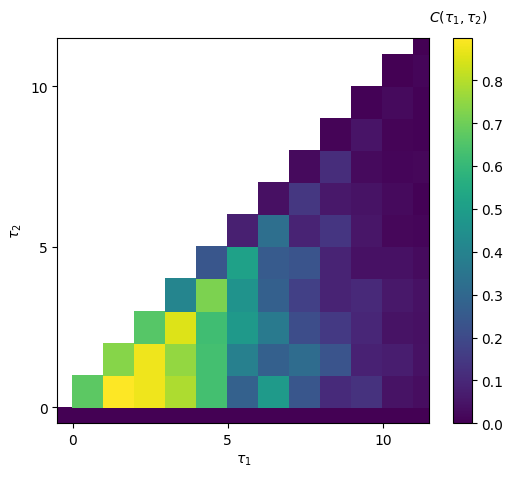

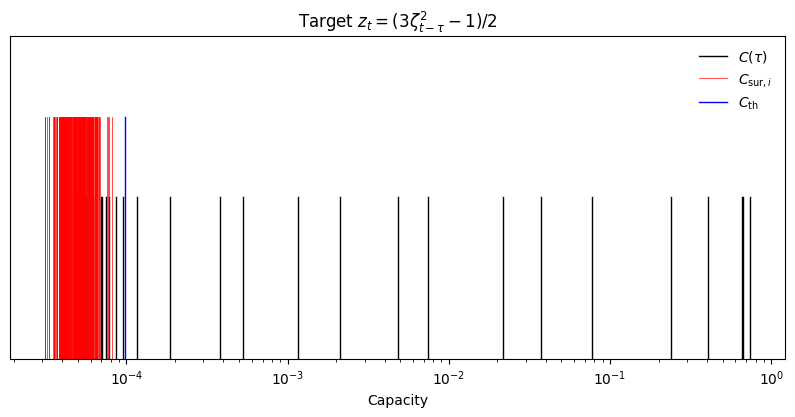

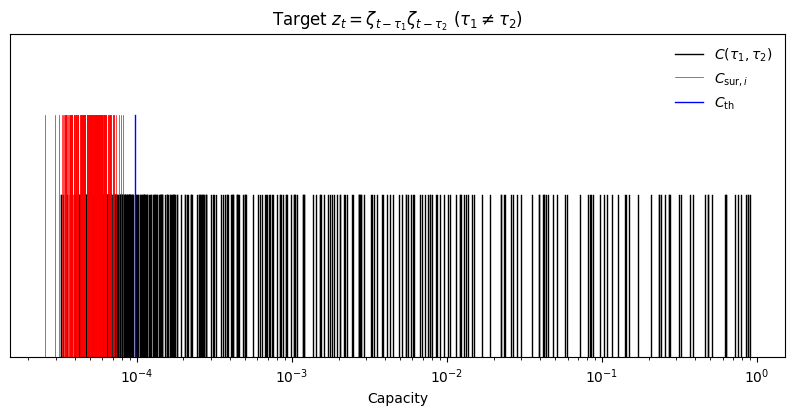

In [ ]:
th_scale = 1.2
delays,mf2d,mf2d_original,surs = ipc.mf2d(path,th_scale=th_scale,return_original=True)

# Diagonal case (i.e., \tau_1=\tau_2)
ipcs_diag = np.diag(mf2d_original)
# Non-diagonal case (i.e., \tau_1\neq\tau_2)
ipcs_nondiag = mf2d_original[np.tri(mf2d_original.shape[0],k=-1).T>0]
print('Diagonal capacities',ipcs_diag,ipcs_diag.shape)
print('Non-diagonal capacities',ipcs_nondiag,ipcs_nondiag.shape)

sur_degdelays = surs.index.values
surs = surs.values
print('Surrogates')
for l,dd,s in zip(['Diagonal','Non-diagonal'],sur_degdelays,surs):
    print(l,dd,s.shape)

# Plot ipc decomposition
fig,ax = plt.subplots(figsize=(6,5))
c = ax.pcolor(delays,delays,mf2d)
fig.colorbar(c, ax=ax)
ax.set_xlim(0,12)
ax.set_ylim(0,12)
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$\tau_2$')
ax.set_xticks([0.5,5.5,10.5])
ax.set_xticklabels([0,5,10])
ax.set_yticks([0.5,5.5,10.5])
ax.set_yticklabels([0,5,10])
ax.text(12,12.5,r'$C(\tau_1,\tau_2)$')

# Plot the surrogates and threshold of diagonal capacities
thr = th_scale*surs[0].max()
plt.figure(figsize=[10,4.2])
plt.plot(ipcs_diag[0]*np.ones(2),[0,1],'k-',lw=1,label=r'$C(\tau)$')
[ plt.plot(c*np.ones(2),[0,1],'k-',lw=1) for c in ipcs_diag[1:]]
plt.plot(surs[0][0]*np.ones(2),[0,1.5],'r-',lw=0.5,label=r'$C_{{\rm sur},i}$')
[ plt.plot(c*np.ones(2),[0,1.5],'r-',lw=0.5) for c in surs[0][1:]]
plt.plot(thr*np.ones(2),[0,1.5],'b-',lw=1,label=r'$C_{\rm th}$')
plt.xlabel('Capacity')
plt.xscale('log')
plt.ylim(0,2)
plt.yticks([])
plt.legend(loc='upper right',frameon=False)
plt.title(r'Target $z_t=(3\zeta_{t-\tau}^2-1)/2$')

# Plot the surrogates and threshold of non-diagonal capacities
thr = th_scale*surs[1].max()
plt.figure(figsize=[10,4.2])
plt.plot(ipcs_nondiag[0]*np.ones(2),[0,1],'k-',lw=1,label=r'$C(\tau_1,\tau_2)$')
[ plt.plot(c*np.ones(2),[0,1],'k-',lw=1) for c in ipcs_nondiag[1:]]
plt.plot(surs[1][0]*np.ones(2),[0,1.5],'r-',lw=0.5,label=r'$C_{{\rm sur},i}$')
[ plt.plot(c*np.ones(2),[0,1.5],'r-',lw=0.5) for c in surs[1][1:]]
plt.plot(thr*np.ones(2),[0,1.5],'b-',lw=1,label=r'$C_{\rm th}$')
plt.xlabel('Capacity')
plt.xscale('log')
plt.ylim(0,2)
plt.yticks([])
plt.legend(loc='upper right',frameon=False)
plt.title(r'Target $z_t=\zeta_{t-\tau_1}\zeta_{t-\tau_2}~(\tau_1\neq\tau_2)$')


#### Mount Your Google Drive
To prevent deleting files that you have created above, you can mount your Google Drive using the following commands:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/ch_5

In [ ]:
!cp -r utils /content/drive/MyDrive/ch_5
!cp -r ipc /content/drive/MyDrive/ch_5

In [ ]:
!ls -l .
!ls -l /content/drive/MyDrive/ch_5

total 136
drwx------ 5 root root  4096 Jun  1 10:02 drive
drwxr-xr-x 4 root root  4096 Jun  1 09:49 ipc
-rw-r--r-- 1 root root 65274 Jun  1 10:26 sample2_1d_memory_function.png
-rw-r--r-- 1 root root 56587 Jun  1 10:26 sample2_1d_surrogate.png
drwxr-xr-x 1 root root  4096 May 30 13:34 sample_data
drwxr-xr-x 3 root root  4096 Jun  1 06:40 utils
total 17
drwx------ 4 root root 4096 Jun  1 10:42  ch_5
drwx------ 2 root root 4096 Apr 22  2022 'Colab Notebooks'
drwx------ 2 root root 4096 Jun  9  2022  Others
-rw------- 1 root root  184 Apr 12 07:46 'RC Seminar in Autumn Semester.gsheet'
drwx------ 2 root root 4096 Jun  9  2022  sample1_esn
total 8
drwx------ 4 root root 4096 Jun  1 10:42 ipc
drwx------ 3 root root 4096 Jun  1 10:42 utils
